# Cooperative Coding in Spiking Neural Networks 
This notebook contains example code to simulate the cooperatively coding spiking networks shown in the main text: <br>
(1) Purely excitatory networks (Fig 8) <br> 
(2) Balanced excitatory-inhibitory networks (Fig 10) <br>
For simulations of the homogeneous spiking networks shown in Section M in S1 Appendix please take a look at supplement.ipynb. 

All spiking network simulations were performed using the Network Simulator Brian2 (https://brian2.readthedocs.io/). 



In [1]:
import brian2 as b2
import json 
import numpy as np
import matplotlib.pyplot as plt 
 
from brian2 import BrianLogger
BrianLogger.log_level_warn()
BrianLogger.suppress_name('resolution_conflict') # suppress unneccessary Brian warnings

from methods import Network, tune_network_analytically, load_parameters
# the Network Class contains all code for setup, simulation, and analysis of the spiking network

# Default parameters 
The directory **parameters/** contains the (optimized) parameter sets for all spiking networks shown in the manuscript. Parameter file names are composed as follows: 
* main/supplement: network architecture from main text (Figs 8,10) or supplement (Fig H Section M in S1 Appendix)
* E/EI: network type (E: purely excitatory, EI: balanced excitatory-inhibitiory)
* nRF: the size of the receptive field (RF) for which the network was tuned

The target peak rate was 150Hz for all parameter sets, as in the paper. 
We provide the numerically optimized parameter sets, i.e. the synaptic weights were optimized for the given nRF by simulating the networks repeatedly.

We show the analytical tuning at the end of this notebook.

**Example:** 
This is how you can load and inspect the parameter set for the purely excitatory network optimized numerically for RF size 9 shown in the main text (Fig 8):

In [2]:
params = load_parameters('main_E_nRF-9', display_description=True)  # main text, excitatory-only, optimized for RF size 9 

|                           | value                                               | description                                                                                                                                                                              |
|:--------------------------|:----------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| I_ex_off                  | 5.52157602533693                                    | (mV) FF drive to exc neurons in unstimulated feature populations                                                                                                                         |
| I_ex_on                   | 10.3998533697286                                    | (mV) FF drive to exc neurons in stimulated feature population                                                                                                                            |
| I_ix_off                  | 0                                                   | (mV) FF drive to inh neurons in unstimulated feature populations                                                                                                                         |
| I_ix_on                   | 0                                                   | (mV) FF drive to inh neurons in stimulated feature population                                                                                                                            |
| J_ee_in                   | 3.2607968849818953                                  | (mV) normalized synaptic weight between excitatory neurons of the same feature population                                                                                                |
| J_ee_out                  | 3.2607968849818953                                  | (mV) normalized synaptic weight between excitatory neurons of different feature populations                                                                                              |
| J_ei_in                   | 0                                                   | (mV) normalized synaptic weight (<0) from inhibitory to excitatory neurons of the same feature population                                                                                |
| J_ei_out                  | 0                                                   | (mV) normalized synaptic weight (<0) from inhibitory to excitatory neurons of different feature populations                                                                              |
| J_ex                      | 0.0                                                 | (mV) normalized synaptic weight from input to excitatory feature population neurons                                                                                                      |
| J_ie_in                   | 0                                                   | (mV) normalized synaptic weight from excitatory to inhibitory neurons of the same feature population                                                                                     |
| J_ie_out                  | 0                                                   | (mV) normalized synaptic weight from excitatory to inhibitory neurons of different feature populations                                                                                   |
| J_ii_in                   | 0                                                   | (mV) normalized synaptic weight (<0) between inhibitory neurons of the same feature population                                                                                           |
| J_ii_out                  | 0                                                   | (mV) normalized synaptic weight (<0) between inhibitory neurons of different feature populations                                                                                         |
| J_ix                      | 0.0                                                 | (mV) normalized synaptic weight from input to inhibitory feature population neurons                                                                                                      |
| N_features                | 41                                                  | (int) number of feature populations                                                                                                                                                      |
| Ne                        | 4000                                                | (int) number of excitatory neurons per feature population                                                                                                                                |
| Ni                        | 0                                                   | (int) number of inhibitory neurons per feature population                                                                                                                                |
| Nx                        | 0                                                   | (int) number of neurons per input population                                                                                                                                             |
| T                         | 3500.0                                              | (ms) total simulation time (Tinit + Tsim)                                                                                                                                                |
| Tinit                     | 500                                                 | (ms) simulation time for initialization (with only background input to all populations)                                                                                                  |
| Tsim                      | 3000.0                                              | (ms) simulation time with stimulation to one feature population                                                                                                                          |
| Vreset                    | 0                                                   | (mV) reset potential                                                                                                                                                                     |
| Vrest                     | 0                                                   | (mV) resting membrane potential                                                                                                                                                          |
| Vthr                      | 10                                                  | (mV) spike threshold                                                                                                                                                                     |
| circulant_ee_connectivity | True                                                | (bool) whether or not to connect the first and last feature population with synapses (periodic boundary condition)                                                                       |
| delay_e_in                | 2                                                   | (ms) delay of excitatory synapses within the same feature population                                                                                                                     |
| delay_e_out               | 2                                                   | (ms) delay of excitatory synapses across different feature populations                                                                                                                   |
| delay_i_in                | 0                                                   | (ms) delay of inhibitory synapses within the same feature population                                                                                                                     |
| delay_i_out               | 0                                                   | (ms) delay of inhibitory synapses across different feature populations                                                                                                                   |
| dt                        | 0.01                                                | (ms) simulation time step                                                                                                                                                                |
| fix_indegree              | True                                                | (bool) whether or not to fix the indegree of recurrent synapses between feature population neurons                                                                                       |
| input_mode                | mean                                                | (str) input mode. mean: only FF mean input changes. gaussian_white_noise: FF mean and variance change poisson-like. poisson: FF input is sampled from Poisson-spiking input populations. |
| ix_on                     | 20                                                  | (int) index of feature population that receives FF stimulation                                                                                                                           |
| nRF_target                | 9                                                   | (int) RF size for which J_ee and I_ex_on were tuned                                                                                                                                      |
| p_ee_in                   | 0.1                                                 | connection probability E-to-E within feature populations                                                                                                                                 |
| p_ee_out                  | 0.1                                                 | connection probability E-to-E across different feature populations                                                                                                                       |
| p_ei_in                   | 0                                                   | connection probability I-to-E within feature populations                                                                                                                                 |
| p_ei_out                  | 0                                                   | connection probability I-to-E across different feature populations                                                                                                                       |
| p_ex                      | 0                                                   | FF connection probability between input and excitatory feature populations                                                                                                               |
| p_ie_in                   | 0                                                   | connection probability E-to-I within feature populations                                                                                                                                 |
| p_ie_out                  | 0                                                   | connection probability E-to-I  across different feature populations                                                                                                                      |
| p_ii_in                   | 0                                                   | connection probability I-to-I within feature populations                                                                                                                                 |
| p_ii_out                  | 0                                                   | connection probability I-to-I across different feature populations                                                                                                                       |
| p_ix                      | 0                                                   | FF connection probability between input and inhibitory feature populations                                                                                                               |
| r_max_target              | 150                                                 | (Hz) peak RF rate for which J_ee and I_ex_on were tuned                                                                                                                                  |
| random_delays             | {'ee': True, 'ei': False, 'ie': False, 'ii': False} | dict of bools, indicating which syn. delays are randomly, uniformly distributed                                                                                                          |
| seed                      | 0                                                   | random seed set before creating and simulating network                                                                                                                                   |
| seed_adjacency            | 0                                                   | random seed for synaptic adjacency with fixed indegree                                                                                                                                   |
| sigma_bg                  | 2                                                   | (mV) strength of iid Gaussian white noise                                                                                                                                                |
| tm                        | 20                                                  | (ms) membrane time constant                                                                                                                                                              |
| tref                      | 0                                                   | (ms) absolute refractory period                                                                                                                                                          |
| verbose                   | True                                                | (bool) enables progress bars and other output                                                                                                                                            |

Side Note: weights $J$ are "normalized" in the sense that they are independent of network size. The actual synaptic weights $w=J/K$ are inferred by dividing by the indegree $K=Np$ along each respective pathway (see scale_weights() in Class Network).

# Network simulations 
We now demonstrate how the code from methods.py can be used to resimulate the networks shown in the main text (see supplement.ipynb for resimulation of supplementary figures).
## Excitatory-only networks (Fig 8) 
### Simulation and analysis
Choose one of the parameter files as the default parameter set and adjust parameters as needed: To decrease simulation time and memory requirements, we recommend to simulate smaller networks (e.g. 500--2000 instead of 4000 excitatory neurons per feature population).

Simulation time: ~ 2 min

In [3]:
params_default_file = 'main_E_nRF-9' # default parameters, here: E-only network from main text, tuned for RF size nRF = 9
params_adjust = {'Ne': 500} # reduce population size to decrease simulation time 

net = Network(params_default_file = params_default_file, params_adjust = params_adjust) # initialize network
net.simulate(Tsim = 800, Tinit = 200, print_schedule=False) # create network and simulate (for a shorter time than in the main text)
net.postproc() # post-simulation analyses (to find stationary rates, RF size, response time)

Load stored adjacency matrix with fixed indegree.
Constructing network...
Equilibrate...
[                                        ----------------------------------------
self.nRF_target=9: mean_rate_center=7, mean_rate_edge=6 Hz
Stimulus on...
[                                        ----------------------------------------
self.nRF_target=9: mean_rate_center=170, mean_rate_edge=7 Hz
[                                        ----------------------------------------
self.nRF_target=9: mean_rate_center=175, mean_rate_edge=8 Hz
[                                        ----------------------------------------
self.nRF_target=9: mean_rate_center=178, mean_rate_edge=7 Hz
[                                        ----------------------------------------
self.nRF_target=9: mean_rate_center=174, mean_rate_edge=8 Hz
Indegrees (mean, SD): self.Kee=(np.float64(150.0), np.float64(0.0)), self.Kei=(0, 0), self.Kie=(0, 0), self.Kii=(0, 0).
Postprocessing: 
Extracting spike trains, keeping 10 neurons pe

100%|██████████| 41/41 [00:00<00:00, 11940.46it/s]


Simulated RF size: 9.57


### Plotting

100%|██████████| 410/410 [00:00<00:00, 445.37it/s]


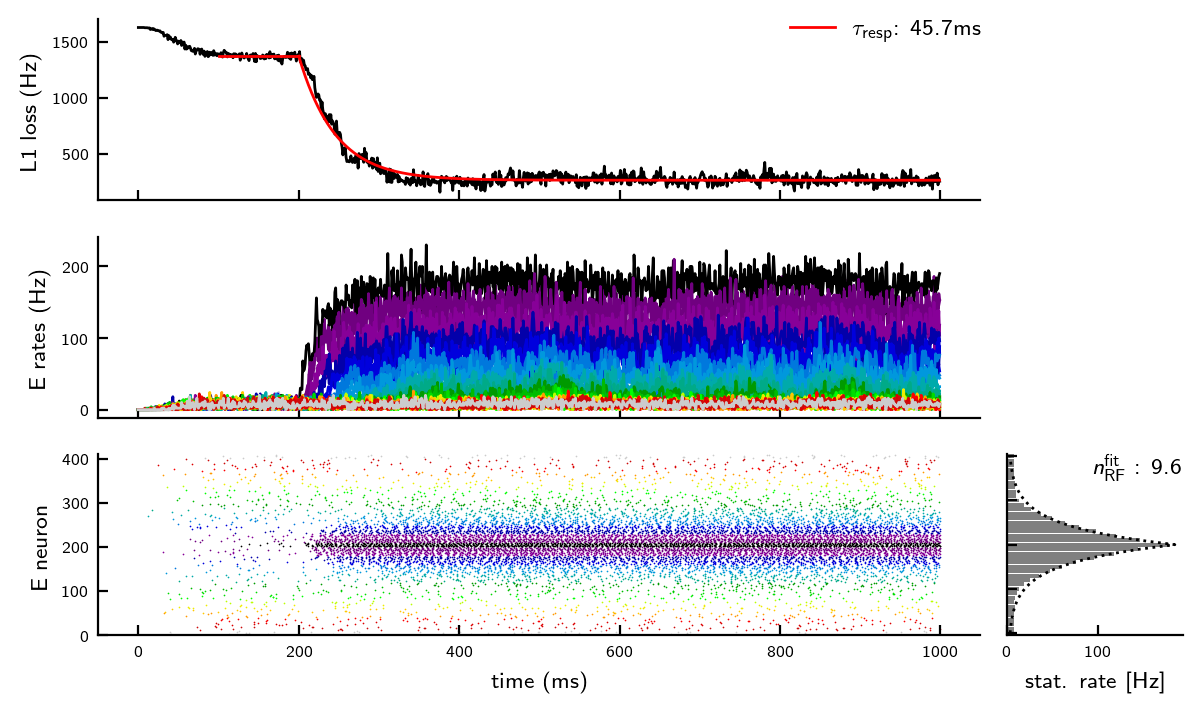

In [4]:
fig, ax = net.plot_sim() # plot simulation results

We set a default rate binning of 1ms in net.postproc(). To plot the rates with a binning of 0.1ms as in the paper run the following:

In [5]:
# net.bin_rates(rate_binsize=0.1) 
# net.plot_sim()

## --alternatively you can also plot the rates smoothed with a Gaussian kernel--
# net.plot_sim(rate_visualization='smoothed')

### Additional inspection of network 
**Weight matrix**: For illustration of the weight matrix, we recommend decreasing the number of neurons per feature population (here: to 20).

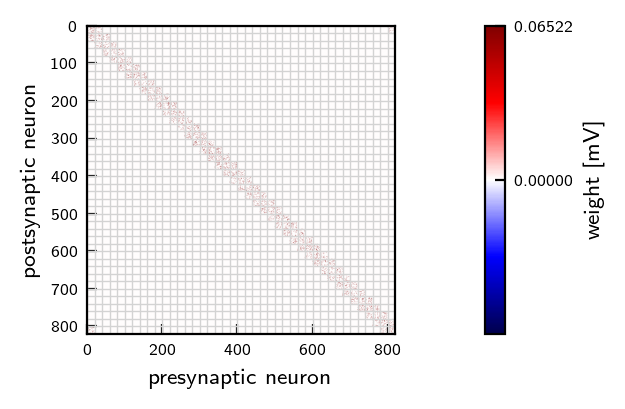

In [6]:
W, fig, ax = net.plot_connectivity(ne = 20) # plot partial weight matrix (showing only 20 excitatory neurons per feature population)

**Feedforward stimulation**: The average feedforward input (top) and strength of Gaussian white noise (bottom) to excitatory (left) and inhibitory (right) feature populations can be illustrated as follows:

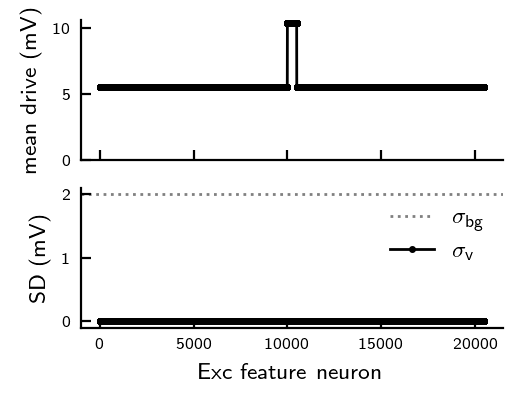

In [ ]:
fig, ax = net.plot_stimulation() # sigma_v is nonzero only for input_mode = 'gaussian_white_noise' (cf. methods.py)

## Balanced Networks (Fig 10) 
Here we resimulate the balanced EI network optimized numerically for RF size 9. 
For other RF sizes, simply load the corresponding default parameter file. 

Rate fluctuations increase with decreasing network size.

Simulation time (for Ne=1000): ~ 6 min

Simulation time (for Ne=2000): ~ 10 min

Load stored adjacency matrix with fixed indegree.
Constructing network...
Equilibrate...
[                                        ----------------------------------------
self.nRF_target=9: mean_rate_center=7, mean_rate_edge=7 Hz
Stimulus on...
[                                        ----------------------------------------
self.nRF_target=9: mean_rate_center=156, mean_rate_edge=6 Hz
[                                        ----------------------------------------
self.nRF_target=9: mean_rate_center=157, mean_rate_edge=7 Hz
[                                        ----------------------------------------
self.nRF_target=9: mean_rate_center=158, mean_rate_edge=6 Hz
[                                        ----------------------------------------
self.nRF_target=9: mean_rate_center=162, mean_rate_edge=6 Hz
Indegrees (mean, SD): self.Kee=(np.float64(600.0), np.float64(0.0)), self.Kei=(np.float64(150.0), np.float64(0.0)), self.Kie=(np.float64(200.0), np.float64(0.0)), self.Kii=(0, 0).
Pos

100%|██████████| 41/41 [00:00<00:00, 3802.97it/s]


Simulated RF size: 9.38


100%|██████████| 410/410 [00:01<00:00, 345.34it/s]


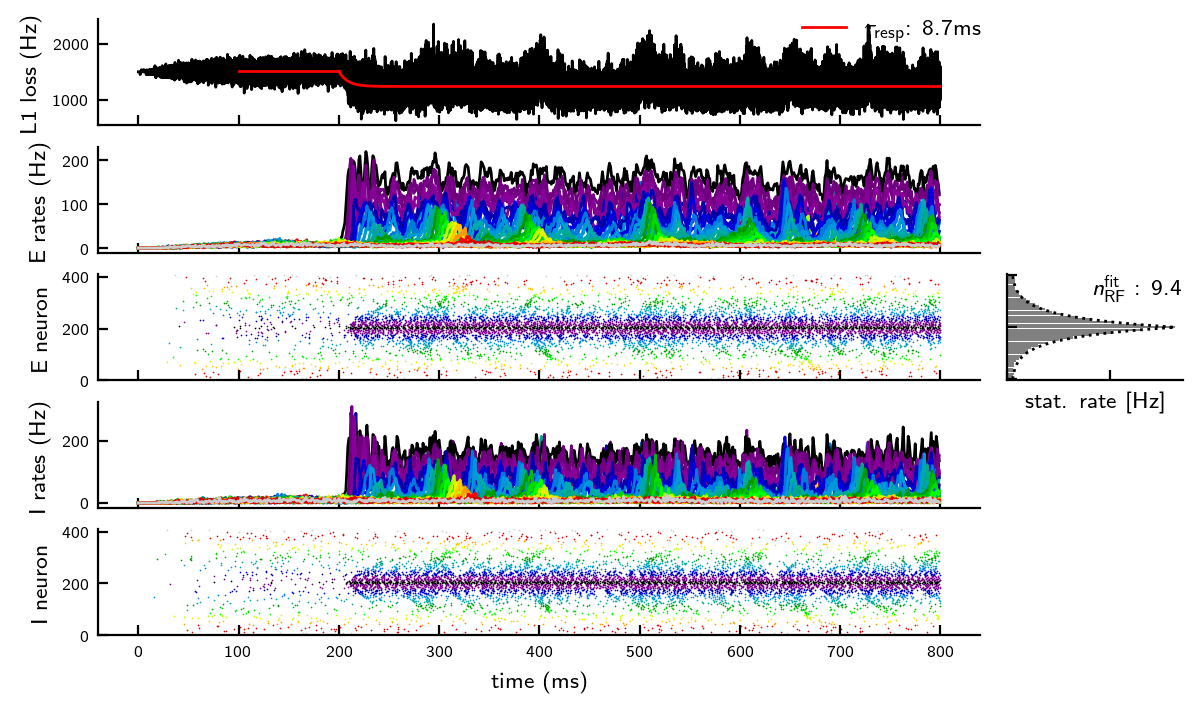

In [8]:
params_default_file = 'main_EI_nRF-9' # EI network tuned for RF size 9
params_adjust = {'Ne': 2000, 'Ni': 500} # decrease network size 

net = Network(params_default_file = params_default_file, params_adjust = params_adjust) # initialize network
net.simulate(Tsim = 600, Tinit = 200, n_intv = 4, print_schedule=False) # simulation can be split into intervals to check for rate explosions  
net.postproc() 
fig, ax = net.plot_sim() 

## Show network connectivity 
To improve visibility we show the same number of neurons for exc and inh feature populations (20 each). 
Neurons are ordered as follows: 

Excitatory neurons of feature population 1,2,..,41 (20 neurons each)

Inhibitory neurons of feature population 1,2,..,41 (20 neurons each)

This yields a total of 2 x 41 x 20 = 1640 neurons.

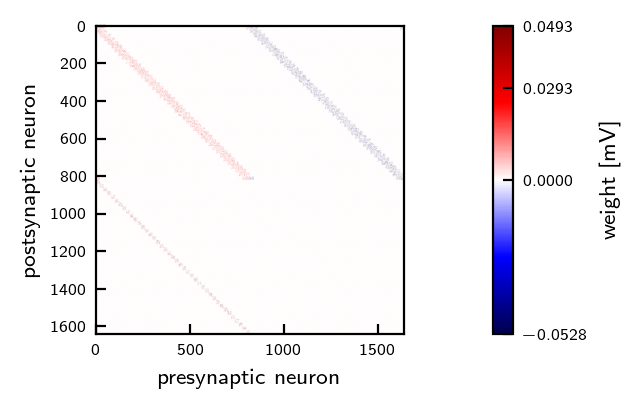

In [9]:
W, fig, ax = net.plot_connectivity(ne = 20, ni=20, mark_feature_populations = False) # plot partial weight matrix (showing only 20 excitatory neurons per feature population)

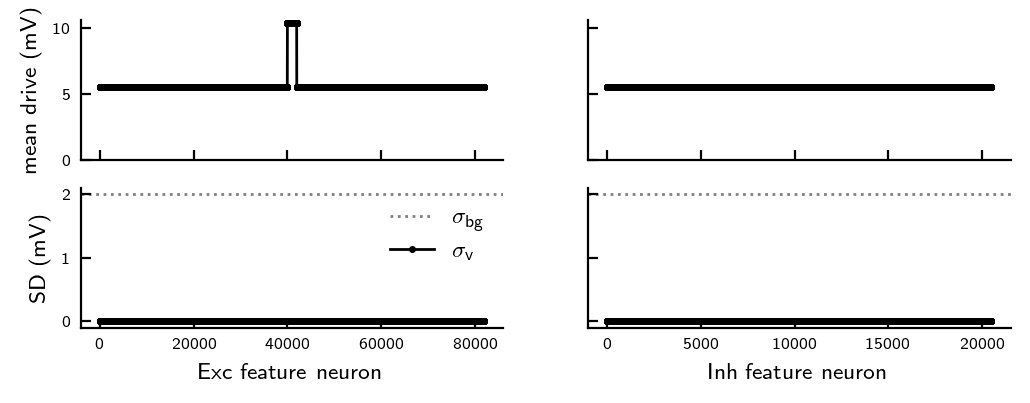

In [10]:
fig, ax = net.plot_stimulation() # note that the interneurons only receive untuned background input

# Analytical Tuning for target RF
The above explored parameter sets (marked as "_opt" in parameters/) were derived in a two step process:

(1) analytical estimate of the parameters J_ee, Iext_on, Iext_off for the given target RF 

(2) numerical optimization of J_ee (synaptic weight) by repeated simulation of the same network with fine weight variations 

Below we demonstrate the analytical parameter estimation (step 1):

Analytically approximated parameters: 
Jee=3.218553371974728, 
Iext_on=10.3998533697286, 
Iext_off=5.521576025336931


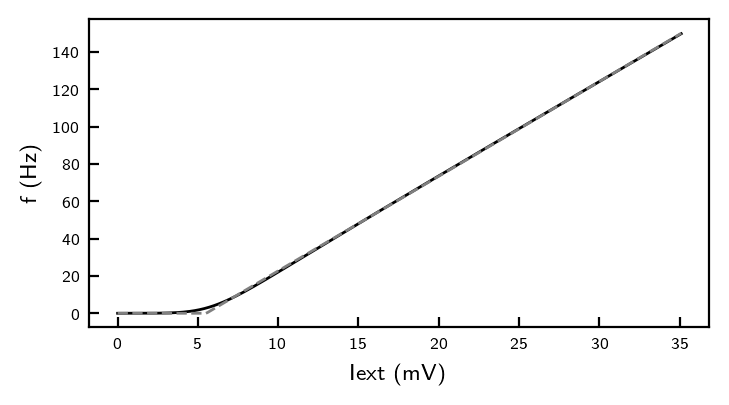

In [11]:
# specify a target RF
n_RF_target = 9 # target RF size 
r_max_target = 150 # target RF peak rate 

# load the general main_E network parameters, not tuned to any specific RF:
net = Network(params_default_file = 'main_E')  

# set parameters analytically
mu0, g = net.fit_transfer_fct(r_max = r_max_target) # threshold-linear fit of fI curve within freq range [0, r_max_target]
J_ee, Iext_on, Iext_off = tune_network_analytically(n_RF_target, r_max_target, g, mu0, net.tm) # analytical approximation of parameters

print(f"Analytically approximated parameters: \nJee={J_ee}, \nIext_on={Iext_on}, \nIext_off={Iext_off}")

Compare to numerically optimized parameters. Note that only the weight Jee is different (increased) in the optimized parameter set:

In [12]:
net_opt = Network(params_default_file = 'main_E_nRF-9') 
print(f"Optimized parameters: \nJee={net_opt.J_ee_out}, \nIext_on={net_opt.I_ex_on}, \nIext_off={net_opt.I_ex_off}")

Optimized parameters: 
Jee=3.2607968849818953, 
Iext_on=10.3998533697286, 
Iext_off=5.52157602533693


#### Network simulation using the analytically tuned synaptic weight:
Note that the analytically tuned network produces a RF that is smaller than the target (nRF~7 instead of 9).

Load stored adjacency matrix with fixed indegree.
Constructing network...
Equilibrate...
[                                        ----------------------------------------
self.nRF_target=nan: mean_rate_center=7, mean_rate_edge=6 Hz
Stimulus on...
[                                        ----------------------------------------
self.nRF_target=nan: mean_rate_center=130, mean_rate_edge=7 Hz
[                                        ----------------------------------------
self.nRF_target=nan: mean_rate_center=129, mean_rate_edge=7 Hz
[                                        ----------------------------------------
self.nRF_target=nan: mean_rate_center=132, mean_rate_edge=7 Hz
[                                        ----------------------------------------
self.nRF_target=nan: mean_rate_center=130, mean_rate_edge=7 Hz
Indegrees (mean, SD): self.Kee=(np.float64(150.0), np.float64(0.0)), self.Kei=(0, 0), self.Kie=(0, 0), self.Kii=(0, 0).
Postprocessing: 
Extracting spike trains, keeping 10 

100%|██████████| 41/41 [00:00<00:00, 11327.00it/s]


Simulated RF size: 6.53


100%|██████████| 410/410 [00:00<00:00, 410.65it/s]


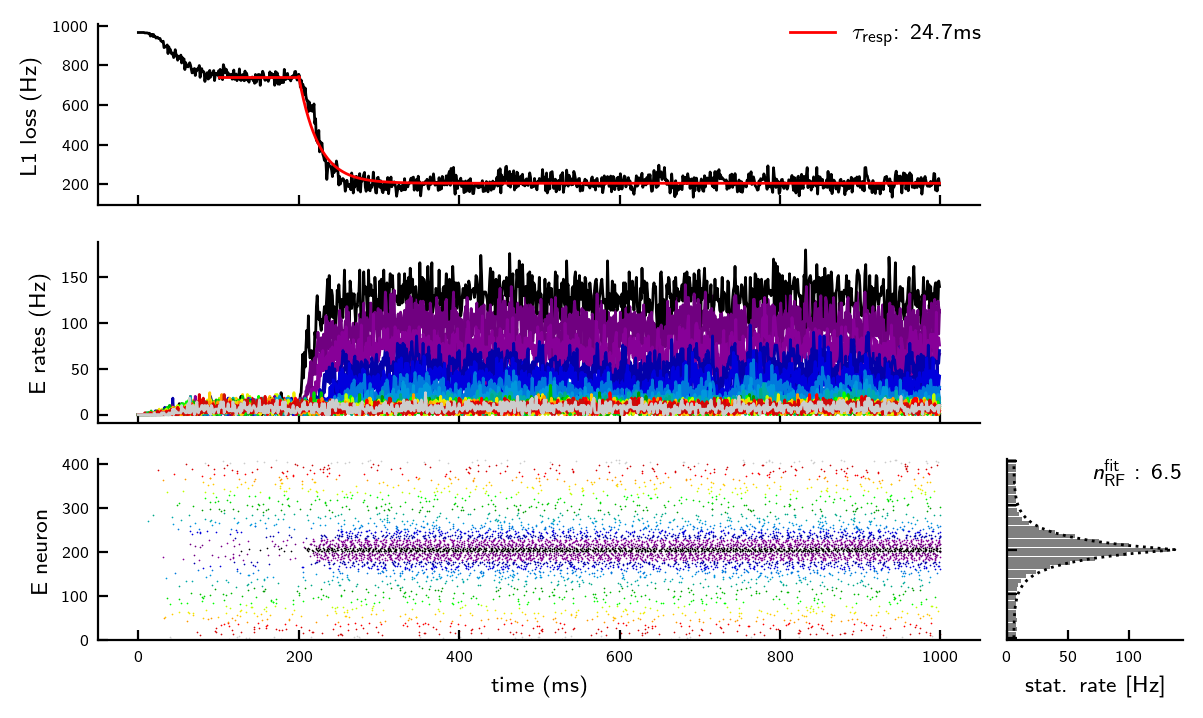

In [13]:
net = Network(params_default_file = f'main_E', 
              params_adjust={'J_ee_out': J_ee, 'J_ee_in': J_ee, 
                             'I_ex_on': Iext_on, 'I_ex_off': Iext_off,
                             'Ne': 500}) 
net.simulate(Tinit = 200, Tsim = 800, print_schedule=False)
net.postproc()
fig, ax = net.plot_sim()